In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image
from bayesian_torch.layers import Conv2dReparameterization, LinearReparameterization
import pandas as pd

# BCNN with Variational Inference 
In this notebook, we aim to **classify images as either fake or real**, a task of growing importance in digital forensics, social media integrity, and misinformation detection. One of the key challenges in this task is **model uncertainty**: being able to not only classify correctly but also to **understand how confident the model is in its predictions**.

To address this, we use **Bayesian Convolutional Neural Networks (Bayesian CNNs)**, which allow us to **estimate uncertainty** directly in the model parameters via **Variational Inference (VI)** in Pytorch. Unlike standard CNNs, Bayesian CNNs **learn distributions over weights**, which lets us quantify how certain the model is in each decision.

This is especially useful in fake image detection where fake examples may look highly similar to real ones and vice versa: uncertainty awareness helps us make more robust decisions.




## Variational Inference in BCNN

Given data $D = \{(x_i, y_i)\}_{i=1}^N $, we want to estimate the **posterior distribution** over model weights $ \omega $ using Bayes' theorem:

$$
p(\omega | D) = \frac{p(D | \omega) p(\omega)}{p(D)}
$$

This posterior is intractable in deep learning, so we use **Variational Inference (VI)** to approximate it with a simpler distribution $ q(\omega) $. We optimize the variational parameters by minimizing the **Kullback-Leibler divergence** between $ q(\omega) $ and the true posterior:

$$
\mathcal{L}_{\text{VI}} = \mathbb{E}_{q(\omega)}[\log p(D | \omega)] - \text{KL}(q(\omega) \| p(\omega))
$$

This is known as the **Evidence Lower Bound (ELBO)**.

In classification tasks, the first term corresponds to the **cross-entropy loss**, and the second is the KL-divergence between the variational posterior over weights $q(\omega)$ and the prior (both usually Gaussians).


## Bayesian CNN Architecture


We design a **Bayesian CNN** to classify images as either **fake or real**.
We use a **Bayesian approach** (via variational inference) instead of deterministic weights. Each layer learns a **probability distribution over its parameters**, which allows us to model **epistemic uncertainty**, a critical feature in fake detection, where inputs can be highly ambiguous.


In variational inference, we approximate the posterior over the true weights $p(\omega \mid D) $ using a tractable variational distribution $q_\theta(\omega)$, Gaussian. So:

- $\omega$: weights 
- $\theta = (\mu, \sigma)$

To optimize $\theta$ we need to differentiate through samples from $q_\theta(\omega)$. This is made possible by the **reparameterization trick**:

$$
\theta = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$


This transforms the stochastic sampling into a deterministic operation involving $\theta$ and noise, enabling backpropagation via automatic differentiation.
The `bayesian-torch` library handles this reparameterization internally; we replace traditional PyTorch layers with:

- `Conv2dReparameterization` instead of `nn.Conv2d`
- `LinearReparameterization` instead of `nn.Linear` 

These layers model weight uncertainty with a Gaussian posterior $ q_\theta(\omega) = \mathcal{N}(\mu, \sigma^2) $, and apply the **reparameterization trick** to sample weights.

### Architecture Details 

- Input: (3, 64, 64) RGB image, images are resized before passing through the model
- Conv Layer 1: A Bayesian convolution with 3 input channels and 32 output filters, kernel size 3×3, padding=1 to preserve spatial size. It is followed by ReLU and 2×2 max pooling, reducing dimensions to (32, 32, 32).

- Conv Layer 2: Takes 32 channels and outputs 64 filters. Same kernel and padding, followed by ReLU and pooling, reducing the spatial resolution to (64, 16, 16).

- Softplus Activation in Bayesian Layers:
Each Bayesian layer models the weight posterior as a Gaussian with parameters $\mu$ and $\sigma$. Since we want values grater than 0 even for $x \leq 0$ we use the **Softplus** function as activation function, otherwise tha variance value $\sigma$ learned during the training could be 0:

$$
\text{Softplus}(x) = \ln(1 + e^x)
$$


- Flattening:
The 3D tensor of shape (64, 16, 16) is flattened into a 1D vector of 16,384 elements. This operation prepares the data to be passed into fully connected layers, which require flat input.

- Fully Connected Layers:

    - fc1: Bayesian linear layer from 16,384 to 128 units, followed by ReLU.

    - fc2: Bayesian linear layer from 128 to 2 output classes (real or fake).

### Forward Pass

During the forward pass, each Bayesian layer samples weights from its learned distribution using the reparameterization trick, which enables backpropagation through random variables. The model thus outputs stochastic predictions, which can be averaged across multiple passes (Monte Carlo sampling) to estimate uncertainty.


In [24]:
class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()
        #first bayesian layer: output 32 feature map
        self.conv1 = Conv2dReparameterization(in_channels=3, out_channels=32, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)  #downsampling
        
        #second bayesian layer: output 64 feature map
        self.conv2 = Conv2dReparameterization(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        #first bayesian fully connected layer
        self.fc1 = LinearReparameterization(in_features=64 * 16 * 16, out_features=128)
        
        #final layer: 2 output classes
        self.fc2 = LinearReparameterization(in_features=128, out_features=2)

    def forward(self, x):
        x, _ = self.conv1(x)  
        x = self.pool(F.relu(x))

        x, _ = self.conv2(x)
        x = self.pool(F.relu(x))

        x = x.view(-1, 64 * 16 * 16)

        x, _ = self.fc1(x)
        x = F.relu(x)

        x, _ = self.fc2(x)
        return x

In [25]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

trainset = datasets.ImageFolder(root='./Downloads/train', transform=transform)
testset = datasets.ImageFolder(root='Downloads/test', transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

## Training the Bayesian CNN

We train the model by minimizing the ELBO loss:

$$
\mathcal{L} = \text{CrossEntropy}(y, \hat{y}) + \lambda \cdot \sum_{l} \text{KL}(q_l(w) \| p(w))
$$

Where:
- $ \text{CrossEntropy}$ : standard classification loss
-  $\lambda$ : scaling factor (usually $\frac{1}{N}$ )
- $\text{KL}(q \| p)$: KL-divergence between posterior and prior for each layer

In each training iteration, we:
1. Sample weights from each layer's variational posterior.
2. Compute output and loss.
3. Backpropagate and update both variational parameters and means/variances of weights.


In [26]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BayesianCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

kl_weight = 1 / len(trainloader)  #weight for KL divergence term 

losses_per_epoch = []

for epoch in range(5):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)  #forward pass
        ce_loss = criterion(outputs, labels)  #Cross-Entropy loss

        #KL-divergence summed over all bayesian layers
        kl = sum(m.kl_loss() for m in model.modules() if hasattr(m, "kl_loss"))

        #Total loss= CE loss + KL divergence= ELBO
        loss = ce_loss + kl_weight * kl
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    losses_per_epoch.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

  0%|          | 0/1563 [00:00<?, ?it/s]C:\Users\ritao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 1563/1563 [10:24<00:00,  2.50it/s] 


Epoch 1, Loss: 0.6760


100%|██████████| 1563/1563 [04:19<00:00,  6.02it/s]


Epoch 2, Loss: 0.4309


100%|██████████| 1563/1563 [04:00<00:00,  6.50it/s]


Epoch 3, Loss: 0.3569


100%|██████████| 1563/1563 [05:17<00:00,  4.93it/s]


Epoch 4, Loss: 0.3056


100%|██████████| 1563/1563 [05:18<00:00,  4.91it/s]

Epoch 5, Loss: 0.2622


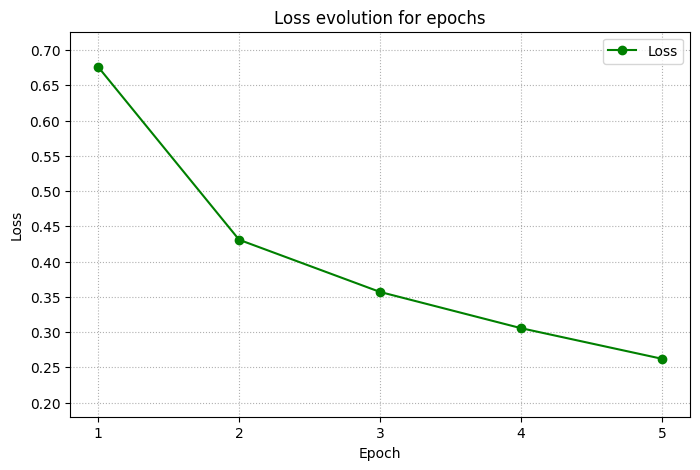

In [52]:
import matplotlib.pyplot as plt


epochs = [1, 2, 3, 4, 5]  
plt.figure(figsize=(8,5))
plt.plot(epochs, losses_per_epoch, marker='o', color='green', label='Loss', linestyle='-')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution for epochs')
plt.grid(True, linestyle=':')
plt.xticks(epochs)  
plt.legend()
plt.yticks(np.arange(0.2, max(losses_per_epoch) + 0.05, 0.05))
plt.ylim(0.18, max(losses_per_epoch) + 0.05)
plt.show()

These values indicate a consistent and steady decrease in the **total loss** during training. This total loss includes both the cross-entropy loss and the KL divergence term introduced by the variational Bayesian layers.

- The decreasing trend suggests that the model is learning meaningful patterns from the training data.

- The use of variational inference allows the model to learn distributions over weights, enabling it to express uncertainty and avoid overfitting, especially useful for real vs. fake classification tasks.

- The inclusion of the KL divergence acts as a regularizer, helping the model remain calibrated and generalizable by preventing overly confident predictions on limited data.

## Monte Carlo VI prediction 

The ELBO objective involves an expectation term:

$$
\mathbb{E}_{q(\omega)}[\log p(D | \omega)]
$$

As introduced before, in classification problems, this term corresponds to the negative cross-entropy between the true labels and the model predictions, where the model parameters (weights) are drawn from the variational posterior $q(\omega)$.

Since this expectation is intractable, we approximate it using **Monte Carlo sampling**: at each forward pass, we sample weights from $q(\omega)$ and compute the cross-entropy loss using those sampled weights. This same sampling principle is used during inference to estimate predictive uncertainty.

The  `mc_vi_predict`function performs Monte Carlo sampling with `T = 30` forward passes, using the Bayesian nature of the model. This technique allows us to estimate both the mean predictions and the uncertainty associated with each prediction. So, it returns:
- `mean_probs`: the average class probabilities across the 30 samples.

- `var_probs`: the epistemic uncertainty, computed as the variance across samples.

- `entropy`: the predictive entropy, which captures the overall uncertainty of the softmax distribution:

$$
H(p) = - \sum_{i} p_i \log (p_i + \epsilon)
$$ ,

where $p_i$ is the means predicted probability for class $i$, and $\epsilon=10^{−8}$ is a small constant for numerical stability.



In [18]:
def mc_vi_predict(model, image_tensor, T=30):
    model.eval()
    preds = []

    with torch.no_grad():
        for _ in range(T):
            output = model(image_tensor)
            prob = F.softmax(output, dim=1)
            preds.append(prob.unsqueeze(0))

    preds = torch.cat(preds, dim=0)  # [T, B, C]
    mean_probs = preds.mean(dim=0)   # [B, C]
    var_probs = preds.var(dim=0)     # epistemic uncertainty
    entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-8), dim=1)

    return mean_probs, var_probs, entropy

The function `evaluate_vi_model` runs the model over the test set and collects predictions along with associated uncertainties. For each image, it stores: 
- the predictive class: fake or real
- the probability of being real
- the epistemic uncertainty: mean variance across classes
- the predictive entropy


In [21]:
import pandas as pd
def evaluate_vi_model(model, testloader, testset, device, T=30, threshold=0.5):
    model.to(device)
    model.eval()
    results = []
    sample_index = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader):
            inputs, labels = inputs.to(device), labels.to(device)

            mean_probs, var_probs, entropy = mc_vi_predict(model, inputs, T=T)

            for i in range(inputs.size(0)):
                prob_real = mean_probs[i, 1].item()
                pred_class = 1 if prob_real >= threshold else 0
                filename = testset.samples[sample_index][0].split('/')[-1]
                sample_index += 1

                results.append({
                    'filename': filename,
                    'true_label': labels[i].item(),
                    'prediction': 'REAL' if pred_class == 1 else 'FAKE',
                    'prob_real': prob_real,
                    'epistemic_uncertainty_mean': var_probs[i].cpu().numpy().mean(),
                    'predictive_entropy': entropy[i].item()
                })

    df = pd.DataFrame(results)
    print(df.head())
    df.to_csv('test_results_vi.csv', index=False)
    return df


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
df = evaluate_vi_model(model, testloader, testset, device, T=30)
#Load the test results
df = pd.read_csv('test_results_vi.csv')

#Map the prediction labels from text to numeric (0 = FAKE, 1 = REAL) to make analysis easier
df['pred_label'] = df['prediction'].map({'FAKE': 0, 'REAL': 1})

#Quick confusion matrix with counts
conf_matrix = pd.crosstab(df['true_label'], df['pred_label'], 
                          rownames=['True'], colnames=['Predicted'])



true_fake_pred_fake = ((df['true_label'] == 0) & (df['pred_label'] == 0)).sum()
true_fake_pred_real = ((df['true_label'] == 0) & (df['pred_label'] == 1)).sum()
true_real_pred_real = ((df['true_label'] == 1) & (df['pred_label'] == 1)).sum()
true_real_pred_fake = ((df['true_label'] == 1) & (df['pred_label'] == 0)).sum()

100%|██████████| 313/313 [15:28<00:00,  2.97s/it]


               filename  true_label prediction  prob_real  \
0  test\FAKE\0 (10).jpg           0       FAKE   0.000225   
1   test\FAKE\0 (2).jpg           0       FAKE   0.003760   
2   test\FAKE\0 (3).jpg           0       FAKE   0.011297   
3   test\FAKE\0 (4).jpg           0       FAKE   0.000746   
4   test\FAKE\0 (5).jpg           0       FAKE   0.092166   

   epistemic_uncertainty_mean  predictive_entropy  
0                1.299914e-07            0.002114  
1                3.024110e-05            0.024745  
2                1.099707e-03            0.061879  
3                7.980587e-07            0.006120  
4                1.444286e-02            0.307520  


The table shows a selection of test samples predicted as FAKE by the model, along with their associated probabilities, epistemic uncertainties, and predictive entropies.

- For the first four samples (0 (10).jpg to 0 (4).jpg), the predicted probability for the “REAL” class (prob_real) is very low (between 0.002 and 0.037), clearly below the decision threshold (0.5). These predictions are highly confident, as confirmed by the very low epistemic uncertainty (close to 0) and low entropy, indicating strong model certainty.

- The fifth sample, 0 (5).jpg, is more interesting: although it is still correctly classified as FAKE, the model assigns a higher prob_real of 0.373, which is much closer to the threshold. This prediction is accompanied by a higher uncertainty (0.0276) and a significantly higher entropy (0.66), suggesting the model is less confident about this particular case. It may represent a more ambiguous or challenging example, possibly with features that resemble real images.

These demonstrate how the model not only makes predictions, but also expresses its confidence, enabling better interpretability.

In [28]:
print("Confusion Matrix (counts):")
print(conf_matrix)

precision = precision_score(df['true_label'], df['pred_label'])
recall = recall_score(df['true_label'], df['pred_label'])
f1 = f1_score(df['true_label'], df['pred_label'])

precision_fake = precision_score(df['true_label'], df['pred_label'], pos_label=0)
recall_fake = recall_score(df['true_label'], df['pred_label'], pos_label=0)
f1_fake = f1_score(df['true_label'], df['pred_label'], pos_label=0)

print(f"\nMetrics for REAL class:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-score: {f1:.4f}")

print(f"\nMetrics for FAKE class:")
print(f"  Precision: {precision_fake:.4f}")
print(f"  Recall:    {recall_fake:.4f}")
print(f"  F1-score:  {f1_fake:.4f}")

accuracy = accuracy_score(df['true_label'], df['pred_label'])
print(f"\nModel Accuracy: {accuracy:.4f}")

Confusion Matrix (counts):
Predicted     0     1
True                 
0          9058   942
1           882  9118

Metrics for REAL class:
  Precision: 0.9064
  Recall: 0.9118
  F1-score: 0.9091

Metrics for FAKE class:
  Precision: 0.9113
  Recall:    0.9058
  F1-score:  0.9085

Model Accuracy: 0.9088


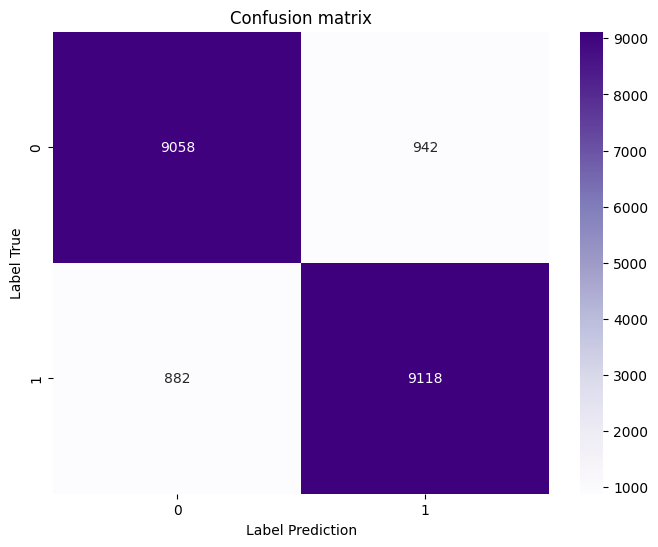

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

confusion_matrix_data = np.array([[9058, 942],
                                  [882,  9118]])
labels = ['0', '1']

plt.figure(figsize=(8, 6))

sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion matrix')
plt.ylabel('Label True')
plt.xlabel('Label Prediction')

plt.show()

The Bayesian CNN model trained with variational inference demonstrates strong and balanced classification performance on the test dataset, achieving an overall accuracy of 90.57%. This indicates that the model correctly classifies the vast majority of images as either real or fake.

The confusion matrix shows the distribution of predictions:

- 9058 true fake images were correctly identified (true negatives),

- 9118 real images were also correctly classified (true positives),

- While 942 fake images were misclassified as real (false positives),

- And 882 real images were misclassified as fake (false negatives).

These numbers are reflected in the precision, recall, and F1-scores:

For the REAL class (positive class):

- Precision: 90.64%, most predictions of real are correct.

- Recall: 91.18%, the model detects nearly all real images.

- F1-score: 90.91%, a good balance between precision and recall.

For the FAKE class:

- Precision: 91.13%, when the model predicts fake, it's usually right.

- Recall: 90.58%, most fake images are successfully identified.

- F1-score: 90.85%, again, strong overall performance.

These results indicate that the model is slightly more cautious when classifying fake images, it prefers to avoid misclassifying a real image as fake (higher precision for fake) at the cost of missing some fake images (slightly lower recall)

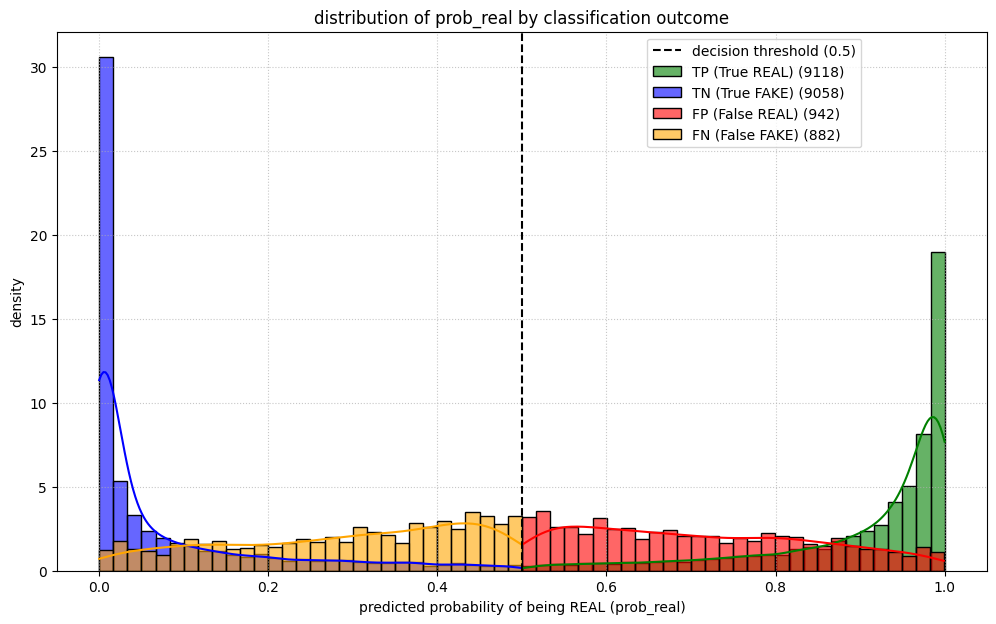

In [60]:
df_results = df.copy()
def get_classification_outcome(row):
    if row['true_label'] == 1 and row['pred_label'] == 1: return 'TP (True REAL)'
    if row['true_label'] == 0 and row['pred_label'] == 0: return 'TN (True FAKE)' # Corrected from VN to TN for consistency
    if row['true_label'] == 0 and row['pred_label'] == 1: return 'FP (False REAL)' # Type I Error
    if row['true_label'] == 1 and row['pred_label'] == 0: return 'FN (False FAKE)' # Type II Error
    return 'Other'

df_results['classification_outcome'] = df_results.apply(get_classification_outcome, axis=1)

plt.figure(figsize=(12, 7))
outcomes_to_plot = ['TP (True REAL)', 'TN (True FAKE)', 'FP (False REAL)', 'FN (False FAKE)']
colors = ['green', 'blue', 'red', 'orange']

for i, outcome in enumerate(outcomes_to_plot):
    subset = df_results[df_results['classification_outcome'] == outcome]
    if not subset.empty:
        sns.histplot(subset['prob_real'], bins=30, label=f"{outcome} ({len(subset)})", color=colors[i], kde=True, stat="density", common_norm=False, alpha=0.6)

plt.title('distribution of prob_real by classification outcome')
plt.xlabel('predicted probability of being REAL (prob_real)')
plt.ylabel('density')
plt.axvline(0.5, color='black', linestyle='--', label='decision threshold (0.5)')
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 1))
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

This graph shows us how prob_real, which is the probability our model gives for an image being REAL, is spread out for different types of correct and incorrect predictions.

* *True Negatives (TN - Blue curve):* These are the 9058 FAKE images that our model correctly identified as FAKE. As we would hope, most of these have a prob_real close to 0. This is a good result, as it means the model is very confident when it correctly spots a fake.

* *True Positives (TP - Green curve):* These are the 9118 REAL images that our model correctly identified as REAL. Most of these have a prob_real close to 1. This is also a good result; the model is confident when it correctly spots a real image.

* *Separation:* The blue and green curves are quite far apart, with the decision line (at 0.5) sitting nicely in between. This shows our model is generally doing a decent job of telling the two classes apart.

* *False Positives (FP - Red curve):* These are the 942 FAKE images that our model mistakenly called REAL. We can see these errors mostly happen when the prob_real is somewhere between 0.5 and about 0.8. So, when the model makes this kind of mistake, it's not usually with extreme confidence, but rather when it's leaning towards REAL without being absolutely certain.

* *False Negatives (FN - Orange curve):* These are the 882 REAL images that our model mistakenly called FAKE. These errors are kind of the mirror image of the FPs, mostly occurring when prob_real is between about 0.2 and 0.5. Again, these mistakes tend to happen when the model is leaning towards FAKE but isn't completely sure.

So, what this tells us is that our model is pretty good at being confident about its correct predictions. When it makes mistakes, it tends to be in that middle zone of probability, where it's not overwhelmingly sure one way or the other. This is useful to know because it highlights the types of situations where our model is more likely to get things wrong.

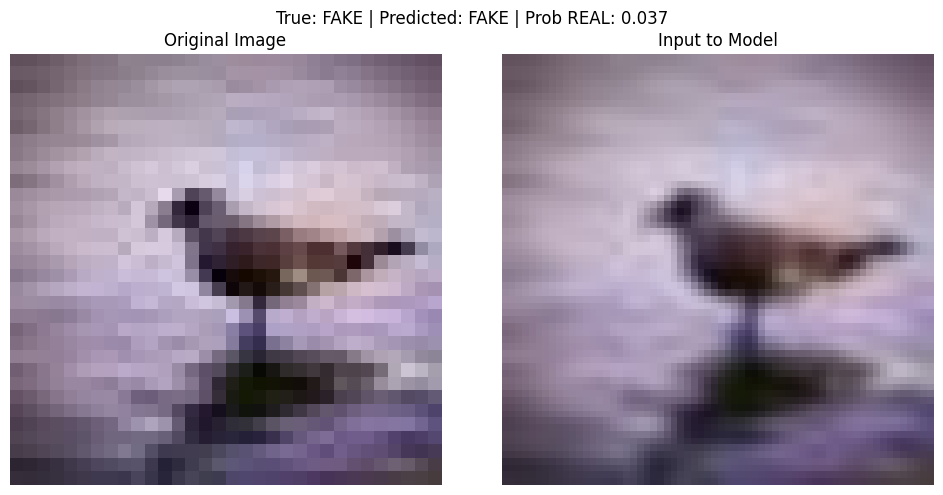

In [36]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


idx = 2  #change the index to see others images
sample = df.iloc[idx]

#path
img_path = os.path.join('Downloads', sample['filename'].replace('\\', os.sep))

#original image
image = Image.open(img_path).convert('RGB')

#apply the transformations
input_tensor = transform(image)

#convert the format[H, W, C]
input_for_display = input_tensor.permute(1, 2, 0).numpy()

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(input_for_display)
axs[1].set_title("Input to Model")
axs[1].axis('off')


plt.suptitle(
    f"True: {'REAL' if sample['true_label'] == 1 else 'FAKE'} | "
    f"Predicted: {sample['prediction']} | Prob REAL: {sample['prob_real']:.3f}",
    fontsize=12
)
plt.tight_layout()
plt.show()


We can see an example of the prediction. The left image is the original image, without changes, that is a FAKE one. Instead, the right image is the transformed one, that is given as input to the model. The model classifies correctly the image, with a probability of being REAL equal to 0.037.

## Comparison: Bayesian CNN vs MC Dropout

Both **Bayesian CNNs** and **Monte Carlo Dropout (MC Dropout)** aim to estimate uncertainty in deep neural networks, but they do so in fundamentally different ways.

### MC Dropout:
- Applies dropout at test time to simulate stochasticity.
- Interprets dropout as an approximation to a variational posterior.
- Easier to implement but provides **coarse uncertainty**.

### Bayesian CNN:
- Learns a full **distribution over weights**.
- Uses explicit **variational inference** to approximate the posterior.
- Offers a **more principled and finer-grained estimate** of epistemic uncertainty.


They show slight differences in behavior and performance in this task.

In terms of overall accuracy, MC Dropout achieves a slightly higher score (92.83%) compared to the Bayesian CNN (90.88%). It also displays more balanced F1-scores between the FAKE and REAL classes (~0.91 for both), suggesting that the model handles class distribution well.

However, when observing the uncertainty estimates, Bayesian CNN appears to provide more nuanced and sharper uncertainty values. For instance, in ambiguous examples like 0 (5).jpg, the Bayesian model’s higher predictive entropy and variance suggest a better ability to identify uncertain or borderline cases. In contrast, MC Dropout's uncertainty values are more uniform and less sensitive, especially in difficult samples, reflecting its coarser approximation of model uncertainty.

Moreover, training loss convergence in MC Dropout is slightly faster and more stable, likely due to its simpler architecture and optimization process. Bayesian CNNs, by contrast, may require more computation and careful tuning but offer a more principled Bayesian treatment of uncertainty.

In summary, MC Dropout provides strong predictive performance with simpler implementation, while Bayesian CNNs offer richer uncertainty information, which could be especially valuable in high-stakes or ambiguous classification scenarios.